# Zalando Clother Classification - Modeling and testing

__Author: Fernández Hernández, Alberto__

__Date: 2023 - 10 - 26__

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.3 MB/s eta 0:00:00


In [94]:
# -- Libraries
from   sklearn.model_selection import train_test_split
from   sklearn.utils           import class_weight
from   sklearn                 import metrics
from   torchvision             import models
from   tqdm                    import tqdm
from   torch.utils             import data
import torch.nn.functional     as F
import torch.nn                as nn
import matplotlib.pyplot       as plt
import numpy                   as np
import pandas                  as pd
import torchvision.transforms  as transforms
import itertools
import torch
import shap
import math
import gzip
import os

In [18]:
# -- Constants and parameters
MAIN_PATH       = '/content/drive/MyDrive/Personal/CentricSoftware'
NPY_FILES       = MAIN_PATH + '/images/'
MODELS_PATH     = MAIN_PATH + '/models/'
MODEL_NAME      = f'{MODELS_PATH}/00_zalando_image_classification_mobilenet_v2_baseline_no_img_aug.pth'
BATCH_SIZE      = 16
RANDOM_STATE    = 1234
EPOCHS          = 15
PATIENT         = 3
LEARNING_RATE   = 5e-05
LOSS_IMPROVE    = 1e-04
MAX_PIXEL_VALUE = 255
NUM_LABELS      = 5
IMG_SIZE        = 224

# -- Specify seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

LABEL_MAPPING = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

CATEGORY_MAPPING = {
    "T-shirt/top": "Upper part",
    "Pullover": "Upper part",
    "Coat": "Upper part",
    "Shirt": "Upper part",
    "Trouser": "Bottom part",
    "Dress": "One piece",
    "Sandal": "Footwear",
    "Sneaker": "Footwear",
    "Ankle boot": "Footwear",
    "Bag": "Bags"
}

GROUP_MAPPING = {
    "Upper part": 0,
    "Bottom part": 1,
    "One piece": 2,
    "Footwear": 3,
    "Bags": 4
}

REVERSE_GROUP_MAPPING = dict((v, k) for k, v in GROUP_MAPPING.items())

In [3]:
f=gzip.open('/content/drive/MyDrive/Personal/CentricSoftware/t10k-images-idx3-ubyte.gz','rb')
file_content=f.read()

In [4]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

## Load data

In [5]:
X_train, y_train = load_mnist('/content/drive/MyDrive/Personal/CentricSoftware', kind='train')

X_train          = np.reshape(X_train, (X_train.shape[0],
                                        int(math.sqrt(X_train.shape[1])),
                                        int(math.sqrt(X_train.shape[1]))
                                        )
                   )

X_test, y_test   = load_mnist('/content/drive/MyDrive/Personal/CentricSoftware', kind='t10k')

X_test           = np.reshape(X_test, (X_test.shape[0],
                                        int(math.sqrt(X_test.shape[1])),
                                        int(math.sqrt(X_test.shape[1]))
                                        )
                   )

## Convert labels into groups

In [6]:
# -- Train labels
y_train_df = pd.DataFrame({'label': y_train})
y_train_df['label_str'] = y_train_df['label'].map(LABEL_MAPPING)

# -- Test labels
y_test_df = pd.DataFrame({'label': y_test})
y_test_df['label_str'] = y_test_df['label'].map(LABEL_MAPPING)

# -- Convert to groups
y_train_df['category'] = y_train_df['label_str'].map(CATEGORY_MAPPING)
y_test_df['category']  = y_test_df['label_str'].map(CATEGORY_MAPPING)

# -- Filter and rename columns
y_train_df = pd.DataFrame(y_train_df['category'].apply(lambda x: GROUP_MAPPING[x]))
y_test_df  = pd.DataFrame(y_test_df['category'].apply(lambda x: GROUP_MAPPING[x]))

y_train_df.rename(columns={'category': 'label'}, inplace=True)
y_test_df.rename(columns={'category': 'label'}, inplace=True)

### Perform train & validation split

In [7]:
y_train_df.reset_index(inplace=True)
X, y = y_train_df[['index']], y_train_df[['label']]
_, _, y_train_df, y_val_df = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [8]:
y_train_df.value_counts(sort=False)

label
0        19200
1         4800
2         4800
3        14400
4         4800
dtype: int64

In [9]:
y_val_df.value_counts(sort=False)

label
0        4800
1        1200
2        1200
3        3600
4        1200
dtype: int64

### Save images as .npy files

In [10]:
y_train_df.reset_index(inplace=True), y_val_df.reset_index(inplace=True), y_test_df.reset_index(inplace=True)

(None, None, None)

In [12]:
!mkdir $NPY_FILES
train_indexes_list = list(y_train_df['index'])
for index_ in tqdm(train_indexes_list):
  np.save(NPY_FILES + 'train_image_{:05d}.npy'.format(index_), X_train[int(index_)])

100%|██████████| 48000/48000 [03:58<00:00, 201.57it/s]


In [13]:
validation_indexes_list = list(y_val_df['index'])
for index_ in tqdm(validation_indexes_list):
  np.save(NPY_FILES + 'validation_image_{:05d}.npy'.format(index_), X_train[int(index_)])

100%|██████████| 12000/12000 [00:58<00:00, 205.16it/s]


In [14]:
test_indexes_list = list(y_test_df['index'])
for index_ in tqdm(test_indexes_list):
  np.save(NPY_FILES + 'test_image_{:05d}.npy'.format(index_), X_test[int(index_)])

100%|██████████| 10000/10000 [00:48<00:00, 207.34it/s]


__Get mean and standard deviation__

NOTE: MEAN and STD must be extracted ONLY from the training set

In [11]:
train_indexes_list = list(y_train_df['index'])
MEAN = np.mean(X_train[train_indexes_list,:,:]); STD = np.std(X_train[train_indexes_list,:,:])
MEAN, STD

(72.96911585884354, 90.03119247281305)

In [16]:
# -- Save labels as .csv files
y_train_df.to_csv(MAIN_PATH + '/train_labels.csv', sep=';', index=False)
y_val_df.to_csv(MAIN_PATH + '/val_labels.csv', sep=';', index=False)
y_test_df.to_csv(MAIN_PATH + '/test_labels.csv', sep=';', index=False)

# Define Model Architecture

In [12]:
# Step 1. Define ZalandoDataset class
class ZalandoDataset(data.Dataset):
    def __init__(self, transform=False, data_type='Train', images_list=None):
        super().__init__()
        self.transform    = transform
        self.data_type    = data_type
        self.images_list  = images_list
        self.records      = None

        if self.data_type == 'Train':
            self.labels      = pd.read_csv(MAIN_PATH + '/train_labels.csv', sep=';')
            self.records     = [NPY_FILES + file_ for file_ in images_list if 'train_image' in file_]
        elif self.data_type == 'Validation':
            self.labels      = pd.read_csv(MAIN_PATH + '/val_labels.csv', sep=';')
            self.records     = [NPY_FILES + file_ for file_ in images_list if 'validation_image' in file_]
        elif self.data_type == 'Test':
            self.labels      = pd.read_csv(MAIN_PATH + '/test_labels.csv', sep=';')
            self.records     = [NPY_FILES + file_ for file_ in images_list if 'test_image' in file_]
        else:
          assert False, "data_type not admitted. Options available: Train, Validation or Test"

        # Label weights (inverse classes balance)
        labels_list   = list(self.labels['label'])
        weights_      = class_weight.compute_class_weight(class_weight='balanced',
                                                          classes=np.unique(labels_list),
                                                          y=np.array(labels_list))
        self.weights  = torch.FloatTensor(weights_)
        self.transforms = transform = transforms.Compose([
                              transforms.Lambda(lambda x: x.unsqueeze(0).unsqueeze(0)),
                              transforms.Resize((IMG_SIZE, IMG_SIZE)),
                              transforms.Normalize((MEAN,), (STD,)),
                              transforms.Lambda(lambda x: x.squeeze(0,1))
                          ])

    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.records)

    def __getitem__(self, index):
        # Load raw image data for each plane
        path    = self.records[index]
        image_id= int(path.split('_')[-1].replace('.npy', ''))
        img_raw = np.load(path)

        # Standarize data
        img_raw = torch.FloatTensor(img_raw)
        img_raw = self.transforms(img_raw)
        img_raw = img_raw.expand(3, img_raw.size(0), img_raw.size(1))

        label = list(self.labels[self.labels['index'] == image_id]['label'])
        label = torch.tensor(label)

        # Return pre-processed image and label
        return img_raw, label

In [13]:
# -- Number of total images: 70k
image_list = os.listdir(NPY_FILES)
len(image_list)

70000

In [14]:
# Get dataset
train_dataset = ZalandoDataset(images_list=image_list)
val_dataset   = ZalandoDataset(data_type='Validation', images_list=image_list)
test_dataset  = ZalandoDataset(data_type='Test', images_list=image_list)

In [15]:
train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=BATCH_SIZE,
                shuffle=True, drop_last=False, num_workers=2)

val_loader  =  torch.utils.data.DataLoader(
                val_dataset, batch_size=BATCH_SIZE,
                shuffle=False, drop_last=False, num_workers=2)

test_loader =  torch.utils.data.DataLoader(
                test_dataset, batch_size=BATCH_SIZE,
                shuffle=False, drop_last=False, num_workers=2)

## Define the Conv. Model

In [16]:
class CustomMobileNetV2(nn.Module):
    """
    Define MobileNetV2 architecture, which consists of:
      - MobileNetV2
        - Conv2d
        - ...
        - nn.Linear(1280, num_classes)
    """
    def __init__(self, num_classes=NUM_LABELS):
        super(CustomMobileNetV2, self).__init__()

        # Cargar el modelo base MobileNetV2 pre-entrenado
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)

        # Congelar los pesos de las capas del modelo base
        for param in self.mobilenet_v2.parameters():
            param.requires_grad = False

        # Reemplazar la capa completamente conectada (clasificador) para ajustarla a 5 clases
        self.mobilenet_v2.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

In [17]:
model = CustomMobileNetV2()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Error + Callbacks

In [19]:
# Define error criterion and optimize functions
train_criterion = nn.CrossEntropyLoss(weight = train_dataset.weights)
val_criterion   = nn.CrossEntropyLoss(weight = val_dataset.weights)

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=0.01)
# Define callbacks
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
              optimizer, patience=3, factor=0.3, threshold=1e-4, verbose=True
)

## Define metrics

In [25]:
def get_sensitivity_precision(y_true, y_pred):
    """
    Calculate recall (sensitivity), precision and negative predicted value (NPV) for a multi-class image classification task with N classes.

    Args:
    y_true (list): True labels (ground truth) for each sample.
    y_pred (list): Predicted labels for each sample.

    Returns:
    dict: A dictionary containing recall, precision and NPV for each class.
    """
    classes = range(5)
    sensitivity = {}  # Recall
    precision = {}
    npv = {}

    for c in classes:
        # Calculate True Positives (TP), False Negatives (FN), and False Positives (FP) for each class
        TP = sum((y_true[i][c] == 1) and (y_pred[i][c] == 1) for i in range(len(y_true)))
        TN = sum((y_true[i][c] == 0) and (y_pred[i][c] == 0) for i in range(len(y_true)))
        FN = sum((y_true[i][c] == 1) and (y_pred[i][c] == 0) for i in range(len(y_true)))
        FP = sum((y_true[i][c] == 0) and (y_pred[i][c] == 1) for i in range(len(y_true)))

        # Calculate recall (sensitivity) and precision for each class
        sensitivity[REVERSE_GROUP_MAPPING[c]] = TP / (TP + FN) if (TP + FN) > 0 else 0
        precision[REVERSE_GROUP_MAPPING[c]] = TP / (TP + FP) if (TP + FP) > 0 else 0
        npv[REVERSE_GROUP_MAPPING[c]] = TN / (TN + FN) if (TN) > 0 else 0

    return {"recall": sensitivity, "precision": precision, "negative predicted value": npv}

## Define training and validation metrics

In [26]:
# -- Transform predicted values into one-shot
def maximize_index(predicted_values):
  max_indices = np.argmax(predicted_values, axis=1)
  result = np.zeros_like(predicted_values)
  for i in range(result.shape[0]):
      result[i, max_indices[i]] = 1
  return result

In [27]:
# -- Define train function
def train(train_data, model, criterion):
    print('Training...')
    model.train()
    counter = 0
    train_running_loss    = 0.0
    prediction_list       = []
    prediction_proba_list = []
    for input_data, label in tqdm(train_data):
        # Switch to GPU if available
        if torch.cuda.is_available():
            input_data, label = input_data.cuda(), label.cuda()
        counter += 1
        optimizer.zero_grad()
        outputs = model(input_data)

        # Apply softmax activation to get all the outputs between 0 and 1
        outputs_sig  = F.softmax(outputs.data, dim=1).detach().cpu()
        prediction_proba_list.append(itertools.chain(*outputs_sig))
        prediction_list.append(itertools.chain(maximize_index(outputs_sig.numpy())))

        # Loss
        loss     = criterion(outputs.cpu(), label.squeeze(-1).cpu())
        train_running_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update optimizer parameters
        optimizer.step()
    train_loss       = train_running_loss  / counter
    return train_loss, prediction_list

In [28]:
# Define val function
def val(val_data, model, criterion):
    print('Validating...')
    model.eval()
    counter = 0
    val_running_loss      = 0.0
    total                 = 0.0
    prediction_list       = []
    prediction_proba_list = []
    label_list            = []
    label_one_hot         = []

    with torch.no_grad():
      for input_data, label in tqdm(val_data):
          # Again, switch to GPU if available
          if torch.cuda.is_available():
              input_data, label = input_data.cuda(), label.cuda()

          label_numpy   = label.detach().cpu().numpy()
          for label_ in label_numpy:
            label_one_hot_aux = np.zeros(NUM_LABELS)
            label_one_hot_aux[label_] = 1
            label_one_hot.append(label_one_hot_aux)

          label_list.append(label.detach().cpu().numpy())
          counter += 1
          outputs  = model(input_data)

          # Apply softmax activation to get all the outputs between 0 and 1
          outputs_sig = F.softmax(outputs.data, dim=1).detach().cpu()
          prediction_proba_list.append(outputs_sig)
          prediction_list.append(maximize_index(outputs_sig.numpy()))
          total    += label.size(1)

          # Loss
          loss     = criterion(outputs.cpu(), label.squeeze(-1).cpu())
          val_running_loss += loss.item()

      val_loss     = val_running_loss / counter
      # Get Sensitivity/Precision/NPV
      prediction_list = list(itertools.chain(*prediction_list))
      label_list      = list(itertools.chain(*label_list))
      prediction_proba_list = list(itertools.chain(*prediction_proba_list))
      metric_dict  = get_sensitivity_precision(label_one_hot, prediction_list)
    return val_loss, prediction_list, prediction_proba_list, metric_dict

### Define Main loop

In [29]:
!mkdir $MODELS_PATH

mkdir: cannot create directory ‘/content/drive/MyDrive/Personal/CentricSoftware/models/’: File exists


In [30]:
# start the training and validation
train_loss     = []
valid_loss     = []
total_train_predictions = []
total_val_predictions   = []

best_val_loss = float('inf')
best_val_auc  = float(0)

patient_counter = 0

if torch.cuda.is_available():
    model = model.cuda()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_predictions = train(
        train_loader, model, train_criterion
    )
    val_epoch_loss, val_predictions, val_predictions_proba, val_metric_dict = val(
        val_loader, model, val_criterion
    )

    # Call ReduceLR Callback (after validation step)
    scheduler.step(val_epoch_loss)

    if best_val_loss - val_epoch_loss >= LOSS_IMPROVE:
        print("Val loss has improved. From {} to {}. Saving model...".format(best_val_loss, val_epoch_loss))
        best_val_loss   = val_epoch_loss
        patient_counter = 0
        torch.save(model, MODEL_NAME)
    else:
        print("Val loss did not improve")
        patient_counter+=1
        if patient_counter == PATIENT:
            break

    train_loss.append(train_epoch_loss)
    valid_loss.append(val_epoch_loss)
    total_train_predictions.append(train_predictions)
    total_val_predictions.append(val_predictions)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    for k in val_metric_dict.keys():
      print(k)
      print("--------")
      for k_aux in val_metric_dict[k].keys():
        print(k_aux + ': ' + str(np.round(val_metric_dict[k][k_aux], 2)))
      print("-----------------------")
    print()
    print("-"*80)

Epoch 1 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From inf to 0.3275301540195942. Saving model...
Train Loss: 0.6542
Val Loss: 0.3275
recall
--------
Upper part: 0.87
Bottom part: 0.95
One piece: 0.87
Footwear: 0.97
Bags: 0.93
-----------------------
precision
--------
Upper part: 0.96
Bottom part: 0.96
One piece: 0.64
Footwear: 0.99
Bags: 0.86
-----------------------
negative predicted value
--------
Upper part: 0.92
Bottom part: 0.99
One piece: 0.98
Footwear: 0.99
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 2 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From 0.3275301540195942 to 0.24421342651546002. Saving model...
Train Loss: 0.3482
Val Loss: 0.2442
recall
--------
Upper part: 0.88
Bottom part: 0.96
One piece: 0.88
Footwear: 0.99
Bags: 0.94
-----------------------
precision
--------
Upper part: 0.96
Bottom part: 0.98
One piece: 0.67
Footwear: 0.99
Bags: 0.9
-----------------------
negative predicted value
--------
Upper part: 0.92
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 3 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From 0.24421342651546002 to 0.2125354362676541. Saving model...
Train Loss: 0.2926
Val Loss: 0.2125
recall
--------
Upper part: 0.9
Bottom part: 0.96
One piece: 0.9
Footwear: 0.99
Bags: 0.94
-----------------------
precision
--------
Upper part: 0.96
Bottom part: 0.99
One piece: 0.69
Footwear: 0.99
Bags: 0.94
-----------------------
negative predicted value
--------
Upper part: 0.93
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 4 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From 0.2125354362676541 to 0.19979881133884192. Saving model...
Train Loss: 0.2701
Val Loss: 0.1998
recall
--------
Upper part: 0.87
Bottom part: 0.96
One piece: 0.93
Footwear: 0.99
Bags: 0.95
-----------------------
precision
--------
Upper part: 0.97
Bottom part: 0.99
One piece: 0.66
Footwear: 0.99
Bags: 0.93
-----------------------
negative predicted value
--------
Upper part: 0.92
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 5 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From 0.19979881133884192 to 0.19044693462798992. Saving model...
Train Loss: 0.2578
Val Loss: 0.1904
recall
--------
Upper part: 0.87
Bottom part: 0.97
One piece: 0.93
Footwear: 0.99
Bags: 0.96
-----------------------
precision
--------
Upper part: 0.97
Bottom part: 0.99
One piece: 0.67
Footwear: 0.99
Bags: 0.92
-----------------------
negative predicted value
--------
Upper part: 0.92
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 6 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From 0.19044693462798992 to 0.18239038096368312. Saving model...
Train Loss: 0.2477
Val Loss: 0.1824
recall
--------
Upper part: 0.91
Bottom part: 0.97
One piece: 0.9
Footwear: 0.99
Bags: 0.94
-----------------------
precision
--------
Upper part: 0.96
Bottom part: 0.98
One piece: 0.71
Footwear: 1.0
Bags: 0.95
-----------------------
negative predicted value
--------
Upper part: 0.94
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 7 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From 0.18239038096368312 to 0.18142529303083818. Saving model...
Train Loss: 0.2441
Val Loss: 0.1814
recall
--------
Upper part: 0.9
Bottom part: 0.96
One piece: 0.93
Footwear: 0.99
Bags: 0.95
-----------------------
precision
--------
Upper part: 0.97
Bottom part: 0.99
One piece: 0.69
Footwear: 1.0
Bags: 0.94
-----------------------
negative predicted value
--------
Upper part: 0.93
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 8 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From 0.18142529303083818 to 0.17296970477327706. Saving model...
Train Loss: 0.2363
Val Loss: 0.1730
recall
--------
Upper part: 0.9
Bottom part: 0.97
One piece: 0.92
Footwear: 1.0
Bags: 0.96
-----------------------
precision
--------
Upper part: 0.97
Bottom part: 0.98
One piece: 0.72
Footwear: 0.99
Bags: 0.92
-----------------------
negative predicted value
--------
Upper part: 0.93
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 9 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From 0.17296970477327706 to 0.1714839312856396. Saving model...
Train Loss: 0.2318
Val Loss: 0.1715
recall
--------
Upper part: 0.92
Bottom part: 0.97
One piece: 0.89
Footwear: 0.99
Bags: 0.95
-----------------------
precision
--------
Upper part: 0.96
Bottom part: 0.99
One piece: 0.76
Footwear: 1.0
Bags: 0.94
-----------------------
negative predicted value
--------
Upper part: 0.95
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 10 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss did not improve
Train Loss: 0.2293
Val Loss: 0.1716
recall
--------
Upper part: 0.9
Bottom part: 0.98
One piece: 0.91
Footwear: 0.99
Bags: 0.96
-----------------------
precision
--------
Upper part: 0.97
Bottom part: 0.97
One piece: 0.72
Footwear: 1.0
Bags: 0.92
-----------------------
negative predicted value
--------
Upper part: 0.94
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 11 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From 0.1714839312856396 to 0.16557788766051332. Saving model...
Train Loss: 0.2294
Val Loss: 0.1656
recall
--------
Upper part: 0.91
Bottom part: 0.97
One piece: 0.91
Footwear: 0.99
Bags: 0.96
-----------------------
precision
--------
Upper part: 0.97
Bottom part: 0.99
One piece: 0.74
Footwear: 1.0
Bags: 0.94
-----------------------
negative predicted value
--------
Upper part: 0.94
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 12 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From 0.16557788766051332 to 0.16345624194915095. Saving model...
Train Loss: 0.2261
Val Loss: 0.1635
recall
--------
Upper part: 0.9
Bottom part: 0.97
One piece: 0.93
Footwear: 1.0
Bags: 0.96
-----------------------
precision
--------
Upper part: 0.97
Bottom part: 0.99
One piece: 0.72
Footwear: 0.99
Bags: 0.93
-----------------------
negative predicted value
--------
Upper part: 0.94
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 13 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss has improved. From 0.16345624194915095 to 0.16198018832256397. Saving model...
Train Loss: 0.2206
Val Loss: 0.1620
recall
--------
Upper part: 0.91
Bottom part: 0.97
One piece: 0.91
Footwear: 0.99
Bags: 0.96
-----------------------
precision
--------
Upper part: 0.97
Bottom part: 0.98
One piece: 0.73
Footwear: 1.0
Bags: 0.94
-----------------------
negative predicted value
--------
Upper part: 0.94
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 14 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss did not improve
Train Loss: 0.2228
Val Loss: 0.1630
recall
--------
Upper part: 0.89
Bottom part: 0.97
One piece: 0.93
Footwear: 1.0
Bags: 0.96
-----------------------
precision
--------
Upper part: 0.97
Bottom part: 0.99
One piece: 0.7
Footwear: 1.0
Bags: 0.94
-----------------------
negative predicted value
--------
Upper part: 0.93
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 15 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Val loss did not improve
Train Loss: 0.2204
Val Loss: 0.1625
recall
--------
Upper part: 0.92
Bottom part: 0.97
One piece: 0.9
Footwear: 1.0
Bags: 0.95
-----------------------
precision
--------
Upper part: 0.97
Bottom part: 0.98
One piece: 0.75
Footwear: 0.99
Bags: 0.95
-----------------------
negative predicted value
--------
Upper part: 0.95
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------


## Test inference

In [33]:
best_model = torch.load(MODEL_NAME)

In [36]:
# -- Use val function for test data
test_epoch_loss, test_predictions, test_predictions_proba, test_metric_dict = val(
        test_loader, best_model, val_criterion
)

for k in test_metric_dict.keys():
  print(k)
  print("--------")
  for k_aux in test_metric_dict[k].keys():
    print(k_aux + ': ' + str(np.round(test_metric_dict[k][k_aux], 2)))
  print("-----------------------")

Validating...


  0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

recall
--------
Upper part: 0.91
Bottom part: 0.96
One piece: 0.88
Footwear: 0.99
Bags: 0.96
-----------------------
precision
--------
Upper part: 0.96
Bottom part: 0.97
One piece: 0.73
Footwear: 0.99
Bags: 0.92
-----------------------
negative predicted value
--------
Upper part: 0.94
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 1.0
-----------------------


### Confussion matrix

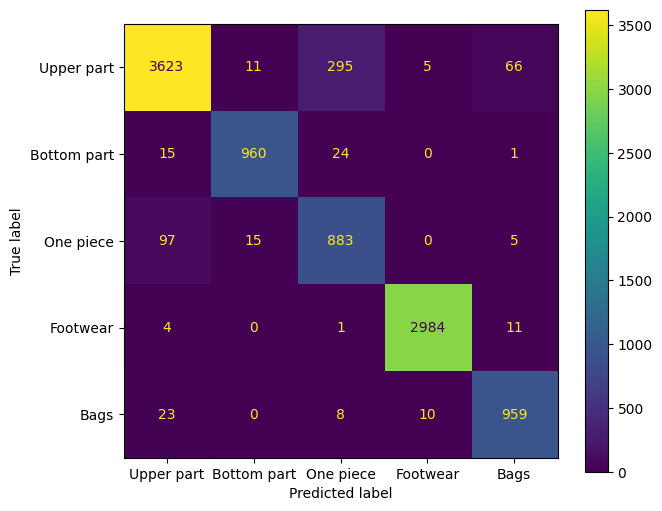

In [61]:
real = list(y_test_df['label'])
pred = [np.argmax(pred) for pred in test_predictions]

cm   = metrics.confusion_matrix(real, pred, labels=list(REVERSE_GROUP_MAPPING.keys()))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GROUP_MAPPING.keys())
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax)
plt.show()

## Slot for NOTES

* 00_zalando_image_classification_mobilenet_v2_baseline_no_img_aug:
  * Model tends to confuse One piece clothes with Upper part ones
  * To sum up: the model is struggling with One Piece clothes

|                  | recall | precision | negative predicted value |
|------------------|-------|-----------|--------------------------|
| Upper part       | 0.91  | 0.96      | 0.94                     |
| Bottom part      | 0.96  | 0.97      | 1.0                      |
| One piece        | 0.88  | 0.73      | 0.99                     |
| Footwear         | 0.99  | 0.99      | 1.0                      |
| Bags             | 0.96  | 0.92      | 1.0                      |


## Error analysis

In [71]:
probabilities = [float(torch.max(proba)) for proba in test_predictions_proba]

y_test_df['pred_label']   = list(map(lambda x: REVERSE_GROUP_MAPPING[x], pred))
y_test_df['str_label']    = y_test_df['label'].apply(lambda x: REVERSE_GROUP_MAPPING[x])
y_test_df['proba_label']  = probabilities

y_test_df

,index,label,pred_label,str_label,proba_label
0,0,3,Footwear,Footwear,0.999651
1,1,0,Upper part,Upper part,0.913029
2,2,1,Bottom part,Bottom part,0.995944
3,3,1,Bottom part,Bottom part,0.997940
4,4,0,Upper part,Upper part,0.946057
...,...,...,...,...,...
9995,9995,3,Footwear,Footwear,0.991235
9996,9996,1,One piece,Bottom part,0.625542
9997,9997,4,Bags,Bags,0.988753
9998,9998,1,Bottom part,Bottom part,0.997768


* 00_zalando_image_classification_mobilenet_v2_baseline_no_img_aug: model tend to confuse One piece clothes with Upper part ones

In [89]:
y_test_df[(y_test_df['str_label'] == 'Upper part') &\
          (y_test_df['pred_label'] == 'One piece') &\
          (y_test_df['proba_label'] < 0.5)].sort_values('proba_label', ascending=True)

,index,label,pred_label,str_label,proba_label
2355,2355,0,One piece,Upper part,0.371105
6874,6874,0,One piece,Upper part,0.392613
6561,6561,0,One piece,Upper part,0.401782
2997,2997,0,One piece,Upper part,0.402535
3239,3239,0,One piece,Upper part,0.421208
737,737,0,One piece,Upper part,0.434625
3454,3454,0,One piece,Upper part,0.437726
7517,7517,0,One piece,Upper part,0.454300
9429,9429,0,One piece,Upper part,0.469922
1586,1586,0,One piece,Upper part,0.475679


In [90]:
indexes = list(y_test_df[(y_test_df['str_label'] == 'Upper part') &\
                         (y_test_df['pred_label'] == 'One piece') &\
                         (y_test_df['proba_label'] < 0.5)]['index']
               )

Image number 719


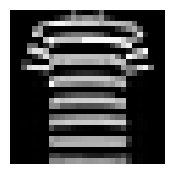

--------------------
Image number 737


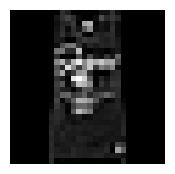

--------------------
Image number 1125


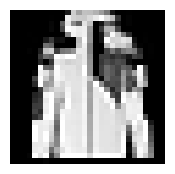

--------------------
Image number 1277


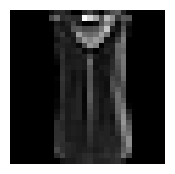

--------------------
Image number 1586


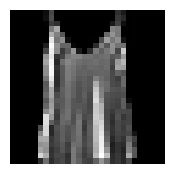

--------------------
Image number 2073


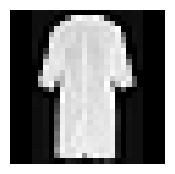

--------------------
Image number 2191


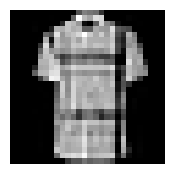

--------------------
Image number 2355


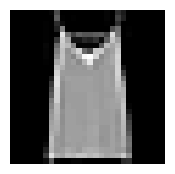

--------------------
Image number 2571


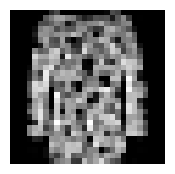

--------------------
Image number 2997


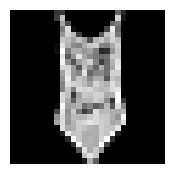

--------------------
Image number 3239


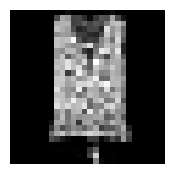

--------------------
Image number 3444


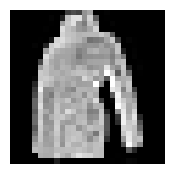

--------------------
Image number 3454


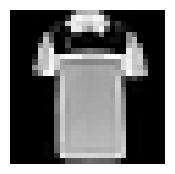

--------------------
Image number 4019


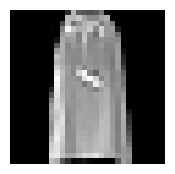

--------------------
Image number 4539


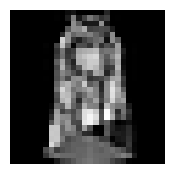

--------------------
Image number 4606


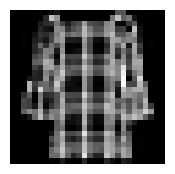

--------------------
Image number 5564


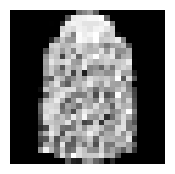

--------------------
Image number 6561


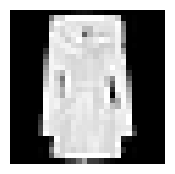

--------------------
Image number 6874


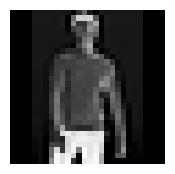

--------------------
Image number 7315


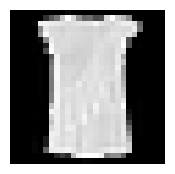

--------------------
Image number 7517


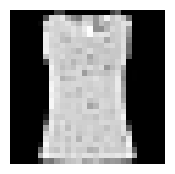

--------------------
Image number 7881


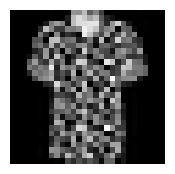

--------------------
Image number 7965


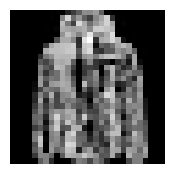

--------------------
Image number 8128


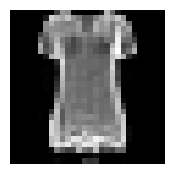

--------------------
Image number 8323


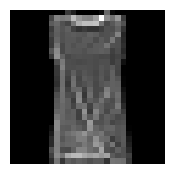

--------------------
Image number 8885


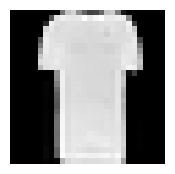

--------------------
Image number 9429


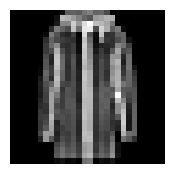

--------------------


In [88]:
for index_ in indexes:
  plt.figure(figsize=(2, 2))
  print("Image number {}".format(index_))
  image = np.load(NPY_FILES + 'test_image_{:05d}.npy'.format(index_))
  plt.imshow(image, cmap='gray', aspect='auto')
  plt.axis('off')
  plt.show()
  print("-" * 20)

## ExplainableAI with Shap

* 00_zalando_image_classification_mobilenet_v2_baseline_no_img_aug: model tend to confuse One piece clothes with Upper part ones

__Define chunk to run exAI with Shap values__

In [336]:
# -- Load model
best_model = torch.load(MODEL_NAME)
if torch.cuda.is_available():
  best_model.to('cuda')

# -- Define transform functions
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((MEAN,), (STD,))
])

# -- Define predict function
def predict(image):
    image  = torch.FloatTensor(image)
    if torch.cuda.is_available():
        image = image.cuda()
    output = model(image)
    return output

# -- 1. Create an explainer with model and image masker
# -- 2. Define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur({},{})".format(IMG_SIZE, IMG_SIZE), (3, IMG_SIZE, IMG_SIZE))

# -- Sample with image number 2191 (shirt)
explainer  = shap.Explainer(predict, masker_blur)
image_list = []
for index_ in indexes:
    if index_ == 2191:
      image = np.load(NPY_FILES + 'test_image_{:05d}.npy'.format(index_))
      image = torch.FloatTensor(image)
      image = transform(image)
      image = image.expand(3, image.size(1), image.size(2))
      image = torch.unsqueeze(image, 0)  # Añade la dimensión batch
      if torch.cuda.is_available():
          image = image.cuda()
      image_list.append(image)

shap_values = explainer(
    image_list[0],
    max_evals=1000,
    batch_size=1,
    outputs=shap.Explanation.argsort.flip[:1],
)

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:36, 36.21s/it]               


In [338]:
# -- Define inverse transform function (to "unstandardize data")
inv_transform = [
    transforms.Normalize(
        mean=(-1 * np.array(MEAN) / np.array(STD)).tolist(),
        std=(1 / np.array(STD)).tolist(),
    )
]
shap_values_data = np.moveaxis((shap_values.data * STD + MEAN).cpu().numpy()[0], 0, -1)
shap_values_values = [np.moveaxis(val, 0, -1) for val in np.moveaxis(shap_values.values[0], -1, 0)]

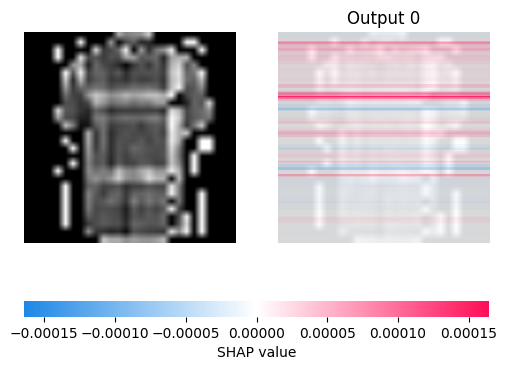

In [340]:
shap.image_plot(
    shap_values=shap_values_values,
    pixel_values=shap_values_data,
    labels=shap_values.output_names
)

## Conclusions for next experiments

* __The results obtained by the model in practically any of the metrics have been very good, except for 'One Piece'.__
* __Model tend to confuse "One Piece" with "Upper Part" label, as we've observed in the confussion matrix__
* __Although the results are generally excellent, the image plots obtained through SHAP values do not reveal any discernible patterns or specific regions where the model is focusing__. To address this, we propose the use of image augmentation techniques:
  * Rotate images (small degree of rotation)
  * Horizontal flip
  * Random Erasing to omit some specific parts of the image. This could help the model focus on particular regions of the image, especially when classifying 'One Piece' images.